In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
## data cleaning
def data_cleaning(data):
    data['dependency']=np.sqrt(data['SQBdependency'])
    data['rez_esc']=data['rez_esc'].fillna(0)
    data['v18q1']=data['v18q1'].fillna(0)
    data['v2a1']=data['v2a1'].fillna(0)
    
    conditions = [
    (data['edjefe']=='no') & (data['edjefa']=='no'), #both no
    (data['edjefe']=='yes') & (data['edjefa']=='no'), # yes and no
    (data['edjefe']=='no') & (data['edjefa']=='yes'), #no and yes 
    (data['edjefe']!='no') & (data['edjefe']!='yes') & (data['edjefa']=='no'), # number and no
    (data['edjefe']=='no') & (data['edjefa']!='no') # no and number
    ]
    choices = [0, 1, 1, data['edjefe'], data['edjefa']]
    data['edjefx']=np.select(conditions, choices)
    data['edjefx']=data['edjefx'].astype(int)
    data.drop(['edjefe', 'edjefa'], axis=1, inplace=True)
    
    meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]
    me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
    for row in meaneduc_nan.iterrows():
        idx=row[0]
        idhogar=row[1]['idhogar']
        m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
        data.at[idx, 'meaneduc']=m
        data.at[idx, 'SQBmeaned']=m*m
    data=data.drop('idhogar',axis=1)
    return data

In [4]:
x_train = data_cleaning(train_df)
x_train = x_train.drop('Id',axis=1)

In [5]:
y_train = x_train.Target
x_train = x_train.drop('Target',axis=1)

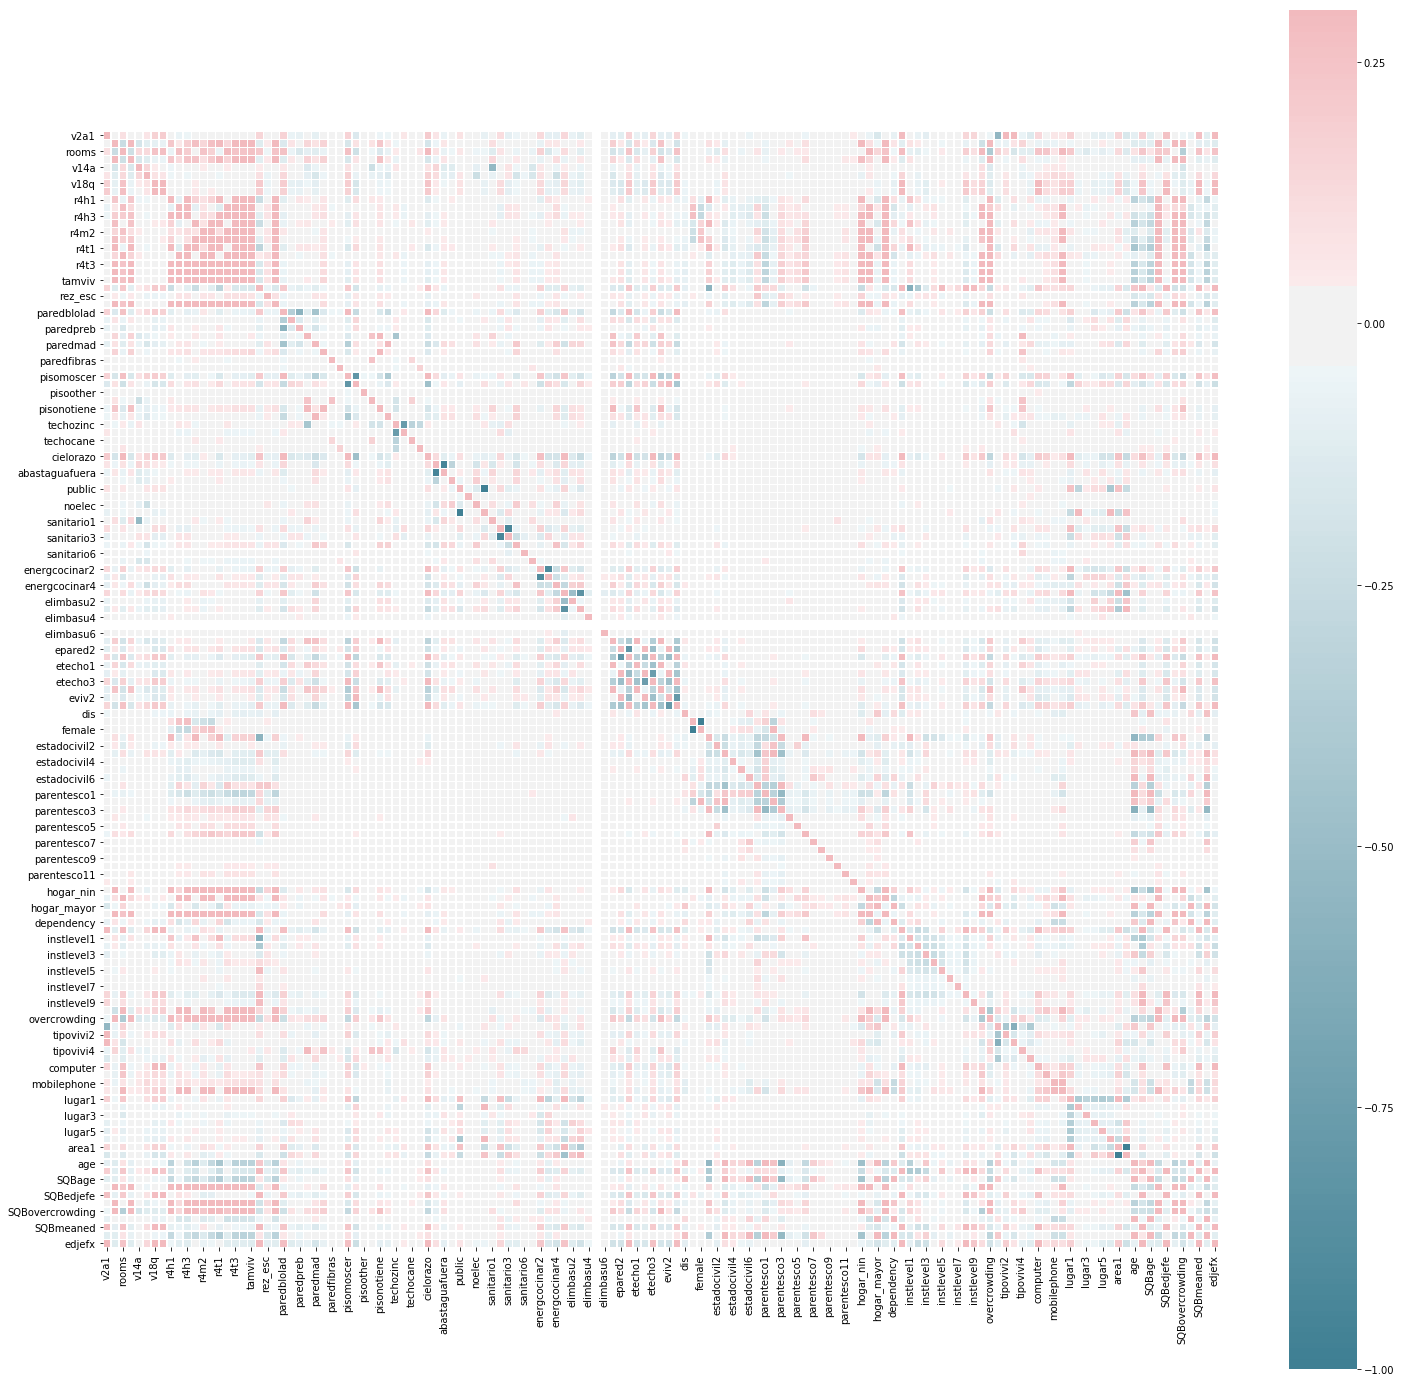

In [7]:
## corr plot
import seaborn as sns
import matplotlib.pyplot as plt
corr = x_train.corr()
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [7]:
%%time
from lightgbm import LGBMClassifier

m3 = LGBMClassifier(n_estimators=3000, max_depth=15)
m3.fit(X_train, y_train)
print(m3.score(X_test,y_test))

0.9550209205020921
Wall time: 14.1 s


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, m3.predict(X_test)))

             precision    recall  f1-score   support

          1       0.94      0.88      0.91       164
          2       0.92      0.91      0.92       305
          3       0.95      0.89      0.92       257
          4       0.97      0.99      0.98      1186

avg / total       0.95      0.96      0.95      1912



c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [9]:
test = data_cleaning(test_df)
ids=test['Id']
test.drop(['Id'], axis=1, inplace=True)
pred = m3.predict(test)
submit=pd.DataFrame({'Id': ids, 'Target': pred})
submit.to_csv('submit.csv', index=False)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
